# Timelag Sandbox
Play around with creating a new object for dealing with cubes of AIA data and computing timelags from them with Dask

In [8]:
import sys
from scipy.interpolate import interp1d
import scipy.integrate
import dask.bytes
import dask.array as da
import dask.dataframe as df
import dask
import distributed
from dask import delayed, compute
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
from astropy.io.fits.hdu.base import BITPIX2DTYPE
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import sunpy.map
from sunpy.util.metadata import MetaDict
from astropy.coordinates import SkyCoord
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.physics.differential_rotation import diffrot_map
#from header_helpers import validate_dtype_shape
from sunpy.instr.aia import aiaprep
#from synthesizAR.instruments import InstrumentSDOAIA

from synthesizAR.analysis import DistributedAIACube,AIATimelags
from synthesizAR.visualize import bgry_004_idl_cmap

sys.path.append('../scripts/')
from idl_procedures import c_correlate

%matplotlib inline

Sandbox for applying interpolation along a given axis of a dask array

In [15]:
foo = da.from_array(np.random.rand(10,1000,1000),chunks=(10,20,20))

In [16]:
bar = np.linspace(0,1,10)
bar_new = np.linspace(0,1,30)

In [17]:
def wrap_np_interp(y):
    return interp1d(bar,y,axis=0,)(bar_new)

In [13]:
#foo_interp = dask.delayed(np.apply_along_axis)(wrap_np_interp, 0, foo)
foo_interp = da.map_blocks(wrap_np_interp, foo, chunks=(30,5,5),dtype=foo.dtype)

In [19]:
foo_interp_res = foo_interp.mean(axis=0)

In [20]:
foo_interp_res

dask.array<mean_agg-aggregate, shape=(100, 100), dtype=float64, chunksize=(5, 5)>

In [2]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1,)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34362 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Construct the Dask array

In [3]:
channels = [94,131,171,193,211,335]

In [4]:
#read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA/{}/map_t*.fits'
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_*_{}_cutout.fits'
#read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA/{}/map_t{:06d}.fits'

In [5]:
#aiatimelags = AIATimeLags(*[DistributedAIACube.from_files([read_template.format(c,i) for i in range(500,2500)]) for c in channels])
aiatimelags = AIATimelags(*[DistributedAIACube.from_files(read_template.format(c,)) for c in channels])

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/synthesizAR-0.1.dev807-py3.6.egg/synthesizAR/analysis/aia.py:163: UserWarning: Time dimensions are not all equal length
  warnings.warn('Time dimensions are not all equal length')


In [7]:
foo = aiatimelags[0].rechunk((aiatimelags[0].shape[0],aiatimelags[0].shape[1]//10,aiatimelags[0].shape[2]//10))

In [8]:
foo_interp = aiatimelags._interpolate(aiatimelags[0].time,foo)

In [9]:
ts = foo[:,245:255,245:255].mean(axis=(1,2)).compute()

In [10]:
ts_interp = foo_interp[:,245:255,245:255].mean(axis=(1,2)).compute()

(60, 80)

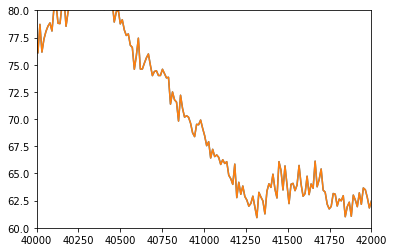

In [41]:
plt.plot(aiatimelags[0].time,ts)
plt.plot(aiatimelags._interpolate_time,ts_interp)
plt.xlim(40000,42000)
plt.ylim(60,80)

In [6]:
cc_335_171 = aiatimelags.correlation_1d('335','171',(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec)).compute()

In [16]:
ts_335 = aiatimelags._interpolate(aiatimelags['335'].time,
                                  aiatimelags.make_timeseries('335',(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))).compute()

In [17]:
ts_171 = aiatimelags._interpolate(aiatimelags['171'].time,
                                  aiatimelags.make_timeseries('171',(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))).compute()

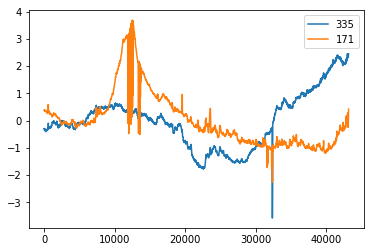

In [23]:
plt.plot(aiatimelags._interpolate_time,(ts_335 - ts_335.mean())/ts_335.std(),label='335')
plt.plot(aiatimelags._interpolate_time,(ts_171 - ts_171.mean())/ts_171.std(),label='171')
plt.legend()

In [18]:
lag_indices = np.array([np.sign(tl)*np.where(np.fabs(tl)==aiatimelags._interpolate_time)[0][0] for tl in aiatimelags.timelags], dtype=int)

In [19]:
%%timeit
cc_335_171_idl = c_correlate(ts_335,ts_171,lag_indices)

87.1 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
aiatimelags['335'].shape[1]*aiatimelags['335'].shape[2] * 0.087 /69

315.2173913043478

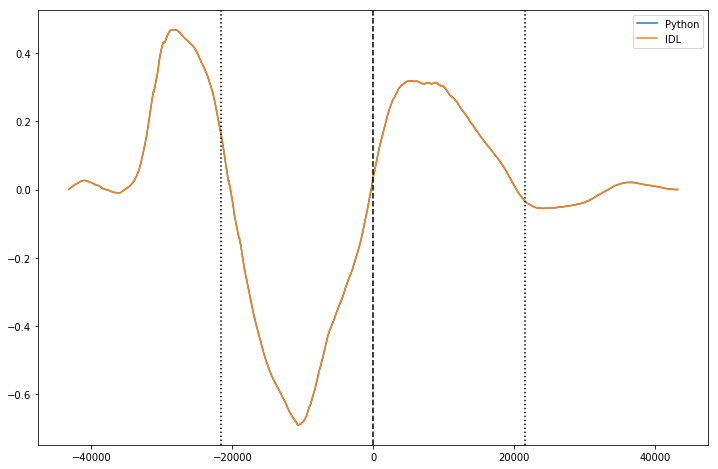

In [59]:
plt.figure(figsize=(12,8))
plt.plot(aiatimelags.timelags,cc_335_171 / ts_335.shape[0],
         label='Python')
plt.plot(aiatimelags.timelags,cc_335_171_idl,
         label='IDL',
         #markevery=100,marker='o',ls=''
        )
plt.axvline(x=(-6*u.hour).to(u.s).value,ls=':',color='k')
plt.axvline(x=(6*u.hour).to(u.s).value,ls=':',color='k')
plt.axvline(x=0,ls='--',color='k')
plt.legend()

In [15]:
cube_335 = aiatimelags['335']
cube_335 = cube_335.rechunk((cube_335.shape[0],cube_335.shape[1]//10,cube_335.shape[2]//10))

In [16]:
cube_335 = aiatimelags._interpolate(aiatimelags._interpolate_time,cube_335)

In [17]:
cube_335

dask.array<interp_wrapper, shape=(3600, 500, 500), dtype=float64, chunksize=(3600, 50, 50)>

In [18]:
cube_171 = aiatimelags['171']
cube_171 = cube_171.rechunk((cube_171.shape[0],cube_171.shape[1]//10,cube_171.shape[2]//10))

In [19]:
cube_171 = aiatimelags._interpolate(aiatimelags._interpolate_time,cube_171)

In [21]:
cube_171

dask.array<interp_wrapper, shape=(3600, 500, 500), dtype=float64, chunksize=(3600, 50, 50)>

In [22]:
std_171 = cube_171.std(axis=0)
std_171 = da.where(std_171 == 0, 1, std_171)
v_171 = (cube_171 - cube_171.mean(axis=0)[np.newaxis, :, :]) / std_171[np.newaxis, :, :]

In [25]:
fft_171 = da.fft.rfft(v_171, axis=0, n=aiatimelags.timelags.shape[0])

In [26]:
fft_171

dask.array<rfft, shape=(3600, 500, 500), dtype=complex128, chunksize=(3600, 50, 50)>

In [46]:
v_171.shape[:1]

(3600,)

In [12]:
cc_335_171_map = aiatimelags.make_correlation_map('335','171',timelag_bounds=(-6*u.hour,6*u.hour),)

In [25]:
tl_335_171_map = aiatimelags.make_timelag_map('335','171',timelag_bounds=(-6*u.hour,6*u.hour),)

1min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


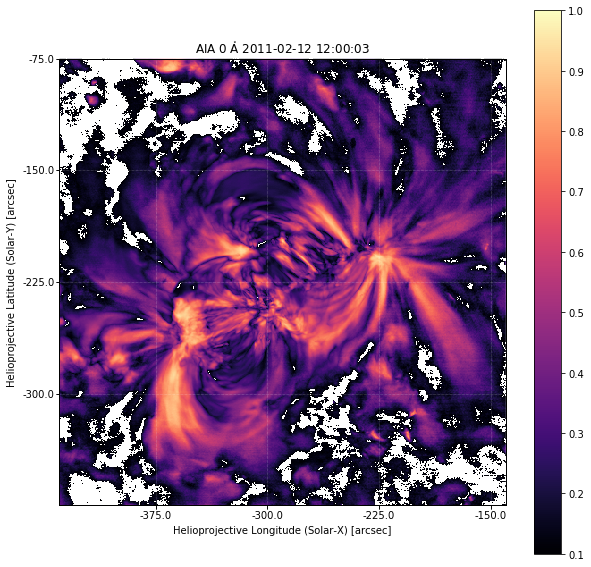

In [34]:
fig = plt.figure(figsize=(10,10))
data = np.where(cc_335_171_map.data < 0.1, np.nan, cc_335_171_map.data)
mask = sunpy.map.GenericMap(data,cc_335_171_map.meta,plot_settings=cc_335_171_map.plot_settings)
ax = fig.gca(projection=mask)
im = mask.plot(axes=ax,
               cmap='magma',
               vmin=0.1,#(-2*u.hour).to(u.s).value,
               vmax=1#(2*u.hour).to(u.s).value
              )
fig.colorbar(im,ax=ax)

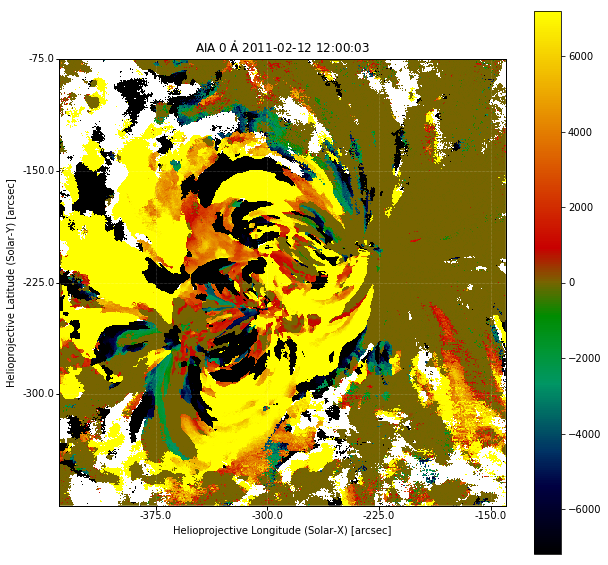

In [14]:
fig = plt.figure(figsize=(10,10))
data = np.where(cc_335_171_map.data < 0.1, np.nan, tl_335_171_map.data)
mask = sunpy.map.GenericMap(data,tl_335_171_map.meta,plot_settings=tl_335_171_map.plot_settings)
ax = fig.gca(projection=mask)
im = mask.plot(axes=ax,
               cmap=bgry_004_idl_cmap,
               vmin=(-2*u.hour).to(u.s).value,
               vmax=(2*u.hour).to(u.s).value)
fig.colorbar(im,ax=ax)

In [41]:
def test_corr(self,channel_a,channel_b):
    if self.needs_interpolation:
        cube_a = self._interpolate(self[channel_a].time, self[channel_a].stacked_data)
        cube_b = self._interpolate(self[channel_b].time, self[channel_a].stacked_data)
    chunks = (cube_a.shape[0], cube_a.shape[1]//10, cube_a.shape[2]//10)
    cube_a = cube_a.rechunk(chunks)
    cube_b = cube_b.rechunk(chunks)
    # Reverse the first timeseries
    cube_a = cube_a[::-1, :, :]
    # Normalize
    std_a = cube_a.std(axis=0)
    std_a = da.where(std_a == 0, 1, std_a)
    v_a = (cube_a - cube_a.mean(axis=0)[np.newaxis, :, :]) / std_a[np.newaxis, :, :]
    std_b = cube_b.std(axis=0)
    std_b = da.where(std_b == 0, 1, std_b)
    v_b = (cube_b - cube_b.mean(axis=0)[np.newaxis, :, :]) / std_b[np.newaxis, :, :]
    # Fast Fourier Transform of both channels
    fft_a = da.fft.rfft(v_a, axis=0, n=self.timelags.shape[0])
    fft_b = da.fft.rfft(v_b, axis=0, n=self.timelags.shape[0])
    # Inverse of product of FFTS to get cross-correlation (by convolution theorem)
    cc = da.fft.irfft(fft_a * fft_b, axis=0, n=self.timelags.shape[0])
    # Normalize by the length of the timeseries
    return cc / cube_a.shape[0]

In [44]:
foo = test_corr(aiatimelags,'335','171').max().compute()

ValueError: x and y arrays must be equal in length along interpolation axis.

In [21]:
ts_test = aiatimelags.make_timeseries('94',(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))

In [24]:
ts_test_interp = aiatimelags._interpolate(aiatimelags['94'].time, ts_test).compute()

In [25]:
ts_test_interp.shape

(3600,)

In [ ]:
cube_test = aiatimelags['171.0'].rechunk((aiatimelags['171.0'].shape[0],
                                          aiatimelags['171.0'].shape[1]//10,
                                          aiatimelags['171.0'].shape[2]//10))
time_test = aiatimelags['171.0'].time

In [ ]:
print(cube_test.shape,cube_test.chunks)

In [ ]:
time_test.shape

In [ ]:
cube_interp = aiatimelags._interpolate(cube_test,time_test)

In [ ]:
fig = plt.figure(figsize=(10,10))
intensity_average = aiatimelags['171.0'].average()
intensity_average = sunpy.map.Map(intensity_average.data.compute(),intensity_average.meta)
ax = fig.gca(projection=intensity_average)
im = intensity_average.plot(axes=ax,)
fig.colorbar(im,ax=ax)

In [ ]:
ts94 = aiatimelags.make_timeseries(94.0,(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))
ts171 = aiatimelags.make_timeseries(171.0,(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))
ts94 = (ts94 - ts94.mean())/ts94.std()
ts171 = (ts171 - ts171.mean())/ts171.std()

In [ ]:
plt.plot(aiatimelags['94.0'].time, ts94)
plt.plot(aiatimelags['171.0'].time, ts171)
#plt.yscale('log')

In [ ]:
cc94_335 = aiatimelags.correlation_1d(94.0,335.0,(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))

In [ ]:
plt.plot(aiatimelags.timelags,cc94_335)

In [ ]:
np.all(np.linspace(aiatimelags['94.0'].time.min(),aiatimelags['94.0'].time.max(),aiatimelags['94.0'].time.shape[0]) == aiatimelags['94.0'].time)

In [ ]:
tl_map94_335 = aiatimelags.make_timelag_map(94.0,335.0,timelag_bounds=(-6*u.hour,6*u.hour))

In [ ]:
cor_map94_335 = aiatimelags.make_correlation_map(94.0,335.0,timelag_bounds=(-6*u.hour,6*u.hour))

In [ ]:
plt.figure(figsize=(12,10))
m_cor = cor_map94_335
m_tl = tl_map94_335
data_tl = np.where(m_cor.data >= 500., m_tl.data, np.nan)
m_tl = sunpy.map.GenericMap(data_tl,m_tl.meta,plot_settings=m_tl.plot_settings)
m_tl.plot(vmin=-(0.5*u.hour).to(u.s).value,
          vmax=(0.5*u.hour).to(u.s).value,
          cmap='RdBu_r',#bgry_004_idl_cmap,
          title=False
         )
plt.colorbar()

In [ ]:
ts1 = distaia.rechunk(distaia.time.shape+(distaia.shape[0]//10,distaia.shape[1]//10))['335'][:,:,250:260].mean(axis=(1,2))
ts2 = distaia.rechunk(distaia.time.shape+(distaia.shape[0]//10,distaia.shape[1]//10))['171'][:,:,250:260].mean(axis=(1,2))

In [ ]:
ts1_scaled = (ts1 - ts1.mean())/ts1.std()
ts2_scaled = (ts2 - ts2.mean())/ts2.std()

In [ ]:
n_timelags = distaia.time.shape[0]*2 - 1

In [ ]:
cc = da.fft.irfft(da.fft.rfft(ts1_scaled[::-1], n=n_timelags)
                  * da.fft.rfft(ts2_scaled, n=n_timelags), n=n_timelags)

In [ ]:
foo = cc.compute()

In [ ]:
i_b = np.where(np.logical_and(timelags >= -(6*u.hour).to(u.s),timelags <= (6*u.hour).to(u.s)))
plt.plot(timelags[i_b],foo[i_b])
plt.xlim((-2*u.hour).to(u.s).value,(2*u.hour).to(u.s).value,)
plt.axvline(x=0,ls='--',color='k')

In [ ]:
read_templates = {wav: read_template.format(wav) for wav in ['94','131','171','193','211','335']}

In [ ]:
filebytes = {wav: dask.bytes.open_files(temp,) for wav, temp in read_templates.items()}

In [ ]:
futures = {wav: client.map(get_header, fnames) for wav, fnames in filebytes.items()}
headers = {wav: client.gather(fut) for wav, fut in futures.items()}

In [ ]:
dtypes = {wav: [validate_dtype_shape(h) for h in head] for wav, head in headers.items()}
dtypes
assert all([d == list(dtypes.values())[0] for d in dtypes.values()])
dtype, shape = list(dtypes.values())[0][0]

In [ ]:
for c in dtypes:
    print(c)
    for i,p in enumerate(dtypes[c]):
        if p != ('float64',[500,500]):
            print(p,c,i)
            raise ValueError(p,c,i)

In [ ]:
list(dtypes.values())[0]

In [ ]:
dtypes['335'][0]

In [ ]:
arrs = {wav: [da.from_array(DelayedFITS(fn, shape=shape, dtype=dtype, hdu=0), chunks=shape)
         for fn in files] for wav, files in filebytes.items()}

In [ ]:
maps = {}
for wav in arrs.keys():
    maps[wav] = [delayed(sunpy.map.sources.AIAMap)(arr, header) for arr, header in zip(arrs[wav], headers[wav])]

In [ ]:
time = u.Quantity([h['t_obs'] for h in headers['94']], headers['94'][0]['tunit'])

In [ ]:
rarrs = {wav: [da.from_delayed(m.data, dtype=np.float64, shape=shape) for m in mps] for wav, mps in maps.items()}

In [ ]:
stacked = {wav: da.stack(arrs) for wav, arrs in rarrs.items()}

In [ ]:
stacked = {wav: d.rechunk(time.shape+(shape[0]//10,shape[1]//10)) for wav, d in stacked.items()}

Now, compute the timelag and correlation maps for each channel pair

In [ ]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [ ]:
timelags = u.Quantity(np.hstack([-np.diff(distaia.time).value.cumsum()[::-1], [0],
                                 np.diff(distaia.time).value.cumsum()]),distaia.time.unit)

In [ ]:
bounds = (-6*u.hour,6*u.hour)
bindices, = np.where(np.logical_and(timelags >= bounds[0], timelags <= bounds[1]))
i_start = bindices[0]
i_stop = bindices[-1] + 1

In [ ]:
correlation_maps = {}
timelag_maps = {}
for ca,cb in channel_pairs[:1]:
    cor = correlation_2d(distaia.rechunk(distaia.time.shape + (distaia.shape[0]//10,distaia.shape[1]//10)),
                         timelags,f'{ca}',f'{cb}')
    # Timelag
    i_timelag = cor[i_start:i_stop,:,:].argmax(axis=0).compute()
    timelag = timelags[i_start:i_stop][i_timelag]
    meta = distaia.headers['94'][0].copy()
    del meta['instrume']
    del meta['t_obs']
    del meta['wavelnth']
    meta['bunit'] = 's'
    meta['comment'] = f'{ca}-{cb} timelag'
    plot_settings = {'cmap': 'RdBu_r', 'vmin': timelags[i_start:i_stop].value.min(),
                     'vmax': timelags[i_start:i_stop].value.max()}
    timelag_maps[f'{ca}-{cb}'] = sunpy.map.GenericMap(timelag,meta,plot_settings=plot_settings)
    # Max correlation
    max_cor = cor[i_start:i_stop,:,:].max(axis=0).compute()
    meta['bunit'] = ''
    meta['comment'] = f'{ca}-{cb} cross-correlation'
    plot_settings['cmap'] = 'plasma'
    del plot_settings['vmin']
    del plot_settings['vmax']
    correlation_maps[f'{ca}-{cb}'] = sunpy.map.GenericMap(max_cor,meta,
                                                          plot_settings=plot_settings)
    

In [ ]:
plt.figure(figsize=(10,10))
m_cor = correlation_maps['94-335']
m_tl = timelag_maps['94-335']
data_tl = np.where(m_cor.data >= 500., m_tl.data, np.nan)
m_tl = sunpy.map.GenericMap(data_tl,m_tl.meta,plot_settings=m_tl.plot_settings)
m_tl.plot(vmin=-(1*u.hour).to(u.s).value,vmax=(1*u.hour).to(u.s).value)
plt.show()

In [ ]:
stack_rechunk = distaia.rechunk(distaia.time.shape + (distaia.shape[0]//10,distaia.shape[1]//10))
ts94 = stack_rechunk['94'][:,250,250]
ts335 = stack_rechunk['335'][:,250,250]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(distaia.time,(ts94 - ts94.mean())/ts94.std(),label='94')
plt.plot(distaia.time,(ts335 - ts335.mean())/ts335.std(),label='335')
#plt.ylim(0,40)

In [ ]:
foo = distaia.maps['94'][0].compute()

In [ ]:
x,y = foo.world_to_pixel(foo.center)

In [ ]:
x,y = x.value//1,y.value//1

In [ ]:
x,y = np.round([x.value,y.value]).astype(np.int)

In [ ]:
x

In [ ]:
foo.data[y,x]

In [ ]:
tuple((np.array(foo.data.shape)//10).tolist())

In [ ]:
foo = np.array([0,1,5,10,11,15,15.5,20])

In [ ]:
np.diff(foo)

In [ ]:
np.gradient(foo)

In [ ]:
min([1*u.s,3*u.s,10*u.s,0*u.s])

In [ ]:
for cube in aiatimelags:
    print(cube.time)